In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [2]:
sns.set(color_codes=True)

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
pd.isnull(test).sum()

Id                 0
DetectedCamera     0
AngleOfSign        0
SignAspectRatio    0
SignWidth          0
SignHeight         0
dtype: int64

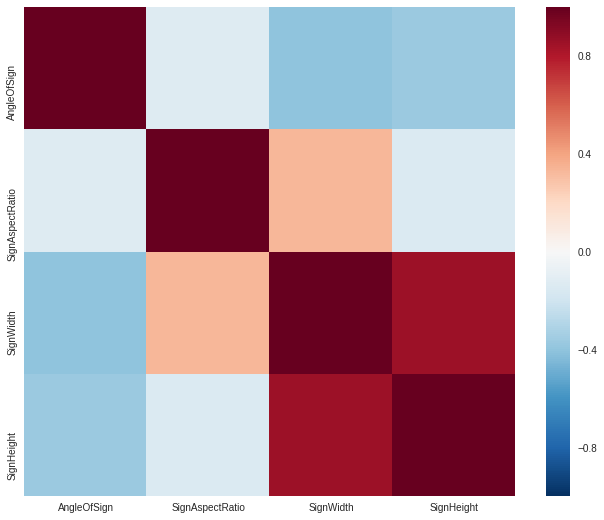

In [5]:
corr=train.corr()
plt.subplots(figsize=(11,9))
sns.heatmap(corr,vmax=1,vmin=-1)


In [6]:
le = LabelEncoder()
le.fit(train.DetectedCamera)

LabelEncoder()

In [7]:
le.classes_

array(['Front', 'Left', 'Rear', 'Right'], dtype=object)

In [8]:
train['DC'] = le.transform(train.DetectedCamera).astype('int64')
train['label'] = le.transform(train['SignFacing (Target)']).astype('int64')

In [9]:
train_array = train.values

In [10]:
test['DC'] = le.transform(test.DetectedCamera).astype('int64')

In [11]:
train_label = train['label']

training = train.drop(labels=['Id', 'DetectedCamera', 'SignFacing (Target)', 'label'], axis=1)
testing = test.drop(labels=['Id', 'DetectedCamera'], axis=1)

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss
from xgboost import XGBClassifier

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [13]:
kfold = KFold(n_splits=5, random_state=7)
model = XGBClassifier(objective="multi:softprob")
params_grid = {'n_estimators':list([250,500,1000,1500,2000,2500,3000]), 'learning_rate':list([0.01, 0.05, 0.75, 0.1, 0.15])}
grid = GridSearchCV(estimator=model, param_grid=params_grid, n_jobs=-1, scoring='log_loss', cv=kfold)
grid.fit(training, train_label)

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to

GridSearchCV(cv=KFold(n_splits=5, random_state=7, shuffle=False),
       error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [250, 500, 1000, 1500, 2000, 2500, 3000], 'learning_rate': [0.01, 0.05, 0.75, 0.1, 0.15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='log_loss', verbose=0)

In [59]:
grid

GridSearchCV(cv=KFold(n_splits=5, random_state=7, shuffle=False),
       error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [250, 500, 1000, 1500, 2000, 2500, 3000], 'learning_rate': [0.01, 0.05, 0.75, 0.1, 0.15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='log_loss', verbose=0)

In [60]:
grid.cv_results_

{'mean_fit_time': array([  432.64461126,   866.45448141,  1710.2513936 ,  2548.92633233,
         3388.35003366,  4225.19929385,  5080.87183118,   425.50302548,
          845.5668026 ,  1707.75896778,  2562.93740911,  3425.38773699,
         4283.45597339,  5147.77989383,   430.60335808,   866.16243134,
         1724.43929157,  2572.63838658,  3425.36884122,  4298.4563056 ,
         5131.89447064,   422.89042735,   848.6663238 ,  1711.34348216,
         2570.00348802,  3434.67998576,  4296.37111998,  5139.30538855,
          421.28300323,   843.96509056,  1716.48014936,  2579.85694547,
         3435.25257502,  4216.72426381,  3523.97160916]),
 'mean_score_time': array([ 0.43288879,  0.94119883,  1.74686141,  2.54148321,  3.58372016,
         4.40923319,  4.70082598,  0.44346056,  0.96234517,  1.88896098,
         2.59920025,  3.70111566,  4.59980917,  6.15464835,  0.56392908,
         1.10943084,  1.83315282,  2.60613961,  3.84108782,  4.88472118,
         5.28586535,  0.54960389,  1.0

In [61]:
grid.best_estimator_

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=250, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [62]:
grid.best_params_

{'learning_rate': 0.1, 'n_estimators': 250}

In [63]:
grid.best_score_

-0.10894155247711837

In [65]:
grid.grid_scores_

/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: -0.18958, std: 0.04624, params: {'n_estimators': 250, 'learning_rate': 0.01},
 mean: -0.11797, std: 0.05183, params: {'n_estimators': 500, 'learning_rate': 0.01},
 mean: -0.11011, std: 0.05182, params: {'n_estimators': 1000, 'learning_rate': 0.01},
 mean: -0.10913, std: 0.05113, params: {'n_estimators': 1500, 'learning_rate': 0.01},
 mean: -0.10900, std: 0.05081, params: {'n_estimators': 2000, 'learning_rate': 0.01},
 mean: -0.10925, std: 0.05094, params: {'n_estimators': 2500, 'learning_rate': 0.01},
 mean: -0.10968, std: 0.05126, params: {'n_estimators': 3000, 'learning_rate': 0.01},
 mean: -0.10939, std: 0.05136, params: {'n_estimators': 250, 'learning_rate': 0.05},
 mean: -0.10928, std: 0.05093, params: {'n_estimators': 500, 'learning_rate': 0.05},
 mean: -0.11262, std: 0.05319, params: {'n_estimators': 1000, 'learning_rate': 0.05},
 mean: -0.11625, std: 0.05562, params: {'n_estimators': 1500, 'learning_rate': 0.05},
 mean: -0.12001, std: 0.05810, params: {'n_estimators': 20

In [66]:
#############################################

True

In [27]:
kfold1 = KFold(n_splits=5, random_state=7)
model1 = XGBClassifier(objective="multi:softprob", n_estimators=250, learning_rate=0.1)
metric1 = 'log_loss'
score = cross_val_score(model1,training, train_label, cv=kfold1, scoring=metric1 )
score.mean()+100

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to

99.89105844752288

In [17]:
score

array([-0.04717858, -0.10043799, -0.20025753, -0.11386928, -0.08327813])

In [67]:
model = XGBClassifier(objective='multi:softprob', n_estimators=200, learning_rate=0.1)
model.fit(training, train_label)
prediction = model.predict_proba(testing)


In [68]:
subm_file = pd.read_csv('sample_submission.csv')



In [69]:
subm_file['Id'] = test['Id']
subm_file['Front'] = prediction[:,0]
subm_file['Left'] = prediction[:,1]
subm_file['Rear'] = prediction[:,2]
subm_file['Right'] = prediction[:,3]

In [70]:
subm_file.to_csv('subm.csv', index=None)